In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [1]:
sys.path.append(os.path.abspath('../scripts'))

import preprocess
import feature_engineering
import model_training


NameError: name 'sys' is not defined

In [3]:
credit_df = preprocess.load_data('../data/creditcard.csv')
credit_df = preprocess.clean_credit_card_data(credit_df)

In [4]:
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']

In [5]:
X_credit_train, X_credit_test, y_credit_train, y_credit_test = model_training.split_data(X_credit, y_credit)


In [6]:
scaler = StandardScaler()
X_credit_train[['Time', 'Amount']] = scaler.fit_transform(X_credit_train[['Time', 'Amount']])
X_credit_test[['Time', 'Amount']] = scaler.transform(X_credit_test[['Time', 'Amount']])

In [7]:
print("Class distribution before SMOTE:", y_credit_train.value_counts())
smote = SMOTE(random_state=42)
X_credit_train_res, y_credit_train_res = smote.fit_resample(X_credit_train, y_credit_train)
print("Class distribution after SMOTE:", y_credit_train_res.value_counts())

Class distribution before SMOTE: Class
0    226602
1       378
Name: count, dtype: int64
Class distribution after SMOTE: Class
0    226602
1    226602
Name: count, dtype: int64
Class distribution after SMOTE: Class
0    226602
1    226602
Name: count, dtype: int64


--- Evaluation Metrics for Logistic Regression (Credit Card) ---
F1-Score: 0.1000
AUC-PR (Area Under Precision-Recall Curve): 0.7150

Confusion Matrix:


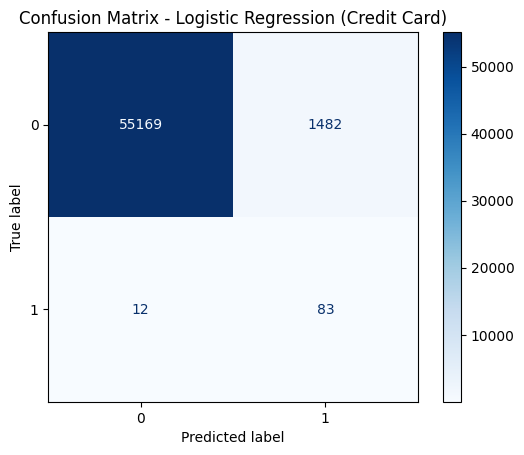

In [8]:
lr_credit_model = model_training.train_logistic_regression(X_credit_train_res, y_credit_train_res)
lr_credit_metrics = model_training.evaluate_model(lr_credit_model, X_credit_test, y_credit_test, "Logistic Regression (Credit Card)")

--- Evaluation Metrics for Random Forest (Credit Card) ---
F1-Score: 0.8276
AUC-PR (Area Under Precision-Recall Curve): 0.8105

Confusion Matrix:


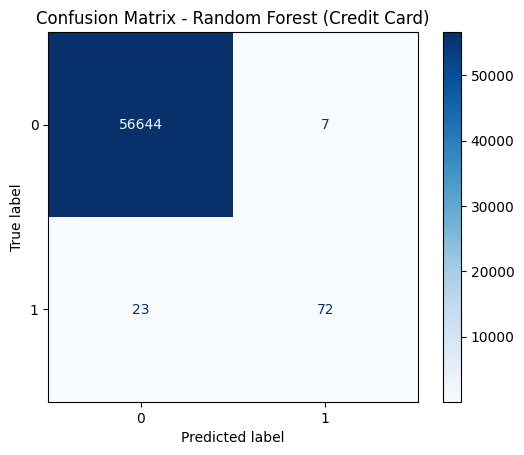

In [9]:
rf_credit_model = model_training.train_random_forest(X_credit_train_res, y_credit_train_res)
rf_credit_metrics = model_training.evaluate_model(rf_credit_model, X_credit_test, y_credit_test, "Random Forest (Credit Card)")

In [10]:
fraud_df = preprocess.load_data('../data/Fraud_Data.csv')
fraud_df = preprocess.clean_fraud_data(fraud_df)

In [11]:
fraud_df = feature_engineering.create_time_features(fraud_df)
fraud_df = feature_engineering.time_since_signup(fraud_df)
fraud_df = fraud_df.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)

In [12]:
X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']

In [13]:
categorical_features = ['source', 'browser', 'sex']
numerical_features = ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup']

In [14]:
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = model_training.split_data(X_fraud, y_fraud)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


--- Evaluation Metrics for Logistic Regression (E-commerce) ---
F1-Score: 0.2689
AUC-PR (Area Under Precision-Recall Curve): 0.4426

Confusion Matrix:


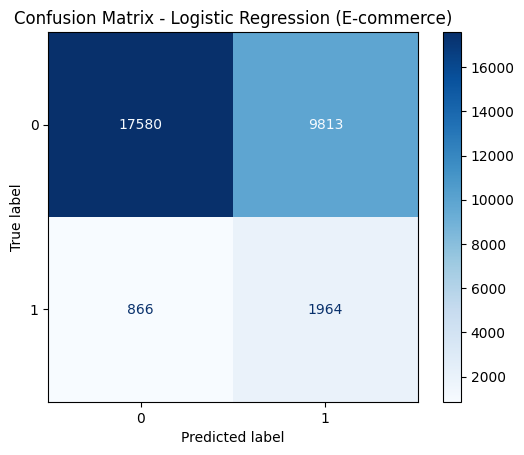

In [ ]:
lr_fraud_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
lr_fraud_pipeline.fit(X_fraud_train, y_fraud_train)
lr_fraud_metrics = model_training.evaluate_model(lr_fraud_pipeline, X_fraud_test, y_fraud_test, "Logistic Regression (Fraud Data)")

--- Evaluation Metrics for Random Forest (E-commerce) ---
F1-Score: 0.6673
AUC-PR (Area Under Precision-Recall Curve): 0.6216

Confusion Matrix:


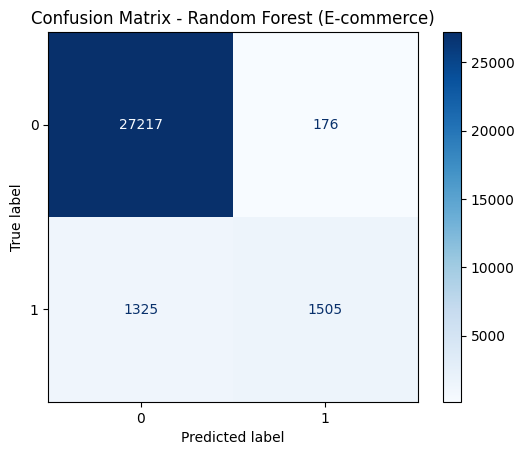

In [17]:
rf_fraud_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])
rf_fraud_pipeline.fit(X_fraud_train, y_fraud_train)
rf_fraud_metrics = model_training.evaluate_model(rf_fraud_pipeline, X_fraud_test, y_fraud_test, "Random Forest (Fraud Data)")

In [18]:
print("\n--- Model Comparison ---")
print("\nCredit Card Dataset:")
print(f"Logistic Regression -> F1: {lr_credit_metrics['f1_score']:.4f}, AUC-PR: {lr_credit_metrics['auc_pr']:.4f}")
print(f"Random Forest -> F1: {rf_credit_metrics['f1_score']:.4f}, AUC-PR: {rf_credit_metrics['auc_pr']:.4f}")


--- Model Comparison ---

Credit Card Dataset:
Logistic Regression -> F1: 0.1000, AUC-PR: 0.7150
Random Forest -> F1: 0.8276, AUC-PR: 0.8105


In [19]:
print("\nE-commerce Dataset:")
print(f"Logistic Regression -> F1: {lr_fraud_metrics['f1_score']:.4f}, AUC-PR: {lr_fraud_metrics['auc_pr']:.4f}")
print(f"Random Forest -> F1: {rf_fraud_metrics['f1_score']:.4f}, AUC-PR: {rf_fraud_metrics['auc_pr']:.4f}")



E-commerce Dataset:
Logistic Regression -> F1: 0.2689, AUC-PR: 0.4426
Random Forest -> F1: 0.6673, AUC-PR: 0.6216
